In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from datahandling import BcomMEG

In [37]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4']
avoid_reading = True
data = BcomMEG(dir=dir, subjects=subjects, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [26]:
data.data

{'BCOM_18_2': {'i_16': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '16': 12>,
  'me_34': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '34': 12>,
  're_144': <EpochsFIF | 8 events (all good), -0.3 – 0.5 s (baseline off), ~4.0 MB, data loaded,
   '144': 8>,
  'sa_52': <EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
   '52': 13>,
  'ra_42': <EpochsFIF | 14 events (all good), -0.3 – 0.5 s (baseline off), ~6.7 MB, data loaded,
   '42': 14>,
  'le_24': <EpochsFIF | 7 events (all good), -0.3 – 0.5 s (baseline off), ~3.5 MB, data loaded,
   '24': 7>,
  'i_116': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '116': 12>,
  'a_112': <EpochsFIF | 16 events (all good), -0.3 – 0.5 s (baseline off), ~7.6 MB, data loaded,
   '112': 16>,
  'ri_146': <EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
  

In [43]:
# first, sepreate out the conditions
a_labels = [a for a in data.data['BCOM_18_2'].keys() if 'a' in a]
e_labels = [e for e in data.data['BCOM_18_2'].keys() if 'e' in e]
i_labels = [i for i in data.data['BCOM_18_2'].keys() if 'i' in i]

for subject in data.data:
    a_epochs = mne.concatenate_epochs([data.data[subject][a] for a in a_labels])
    e_epochs = mne.concatenate_epochs([data.data[subject][e] for e in e_labels])
    i_epochs = mne.concatenate_epochs([data.data[subject][i] for i in i_labels])    


Not setting metadata
90 matching events found
No baseline correction applied
Not setting metadata
54 matching events found
No baseline correction applied
Not setting metadata
62 matching events found
No baseline correction applied
Not setting metadata
70 matching events found
No baseline correction applied
Not setting metadata
63 matching events found
No baseline correction applied
Not setting metadata
72 matching events found
No baseline correction applied
Not setting metadata
58 matching events found
No baseline correction applied
Not setting metadata
56 matching events found
No baseline correction applied
Not setting metadata
77 matching events found
No baseline correction applied


In [52]:
from mne.stats import permutation_cluster_test

permuataion_collection = [a_epochs.get_data(), e_epochs.get_data(), i_epochs.get_data()]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)

Using a threshold of 3.043980
stat_fun(H1): min=2.5895308760466117e-05 max=9.295301215841619
Running initial clustering …
Found 677 clusters


/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_80135/2382917169.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)


  0%|          | Permuting : 0/1999 [00:00<?,       ?it/s]

In [53]:
significant_sensors = np.where(cluster_p_values < 0.05)[0]

In [54]:
significant_sensors

array([], dtype=int64)

### 10 Best sensors based on mutual information

In [67]:
from sklearn.feature_selection import mutual_info_classif

num_a = len(a_epochs)
num_e = len(e_epochs)
num_i = len(i_epochs)
min_trials = (min(num_a, num_e, num_i))

a_rand = a_epochs[np.random.choice(num_a, min(num_a, num_e, num_i), replace=False)]
e_rand = e_epochs[np.random.choice(num_e, min(num_a, num_e, num_i), replace=False)]
i_rand = i_epochs[np.random.choice(num_i, min(num_a, num_e, num_i), replace=False)]

a_data = a_rand.get_data()
e_data = e_rand.get_data()
i_data = i_rand.get_data()

a_flat = a_data.reshape(a_data.shape[0], -1)
e_flat = e_data.reshape(e_data.shape[0], -1)
i_flat = i_data.reshape(i_data.shape[0], -1)


X = np.vstack([a_flat, e_flat, i_flat])
y = np.concatenate([np.ones(min_trials), np.ones(min_trials)*2, np.ones(min_trials)*3])
mi_scores = mutual_info_classif(X, y, random_state=0)
important_sensors = np.argsort(mi_scores)[-10:]



In [75]:
mi_reshaped = mi_scores.reshape(a_data.shape[1], a_data.shape[2])
sensor_mi_scores_reshaped = mi_reshaped.mean(axis=1)
important_sensors = np.argsort(sensor_mi_scores_reshaped)[-10:]
sensor_names = a_epochs.info['ch_names']
important_sensor_names = [sensor_names[i] for i in important_sensors]
print(important_sensor_names)


['MEG 218', 'MEG 081', 'MEG 050', 'MEG 179', 'MEG 125', 'MEG 089', 'MEG 101', 'MEG 006', 'MEG 161', 'MEG 239']


(<matplotlib.image.AxesImage at 0x35fb693a0>, None)

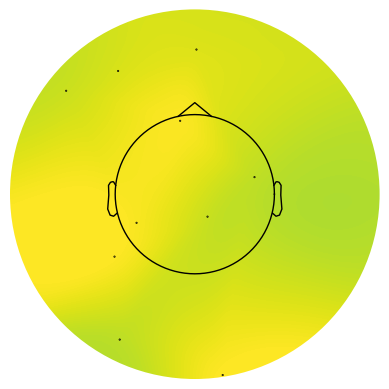

In [128]:
import mne.channels


important_sensor_names
sensor_mi_scores_reshaped[important_sensors]

info = a_epochs.info
picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

pos = mne.channels.layout._find_topomap_coords(info, picks)

data = np.array(sensor_mi_scores_reshaped[important_sensors])

fig, ax = plt.subplots()
mne.viz.plot_topomap(data, pos, axes=ax, show=False, cmap='viridis', contours=0)